In [1]:
! kaggle datasets download pratyushakar/rossmann-store-sales && unzip rossmann-store-sales.zip

Dataset URL: https://www.kaggle.com/datasets/pratyushakar/rossmann-store-sales
License(s): CC0-1.0
 72% 5.00M/6.90M [00:00<00:00, 45.9MB/s]
100% 6.90M/6.90M [00:00<00:00, 52.8MB/s]
Archive:  rossmann-store-sales.zip
  inflating: store.csv               
  inflating: test.csv                
  inflating: train.csv               


In [2]:
!pip install prophet

# Importação base de dados e bibliotecas

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import warnings
from prophet import Prophet

warnings.filterwarnings('ignore')
from scipy.stats import ttest_ind, chi2_contingency
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, root_mean_squared_error

In [4]:
sns.set_style("whitegrid")
sns.set_palette("Set2")

In [5]:
vendas_df = pd.read_csv('train.csv', parse_dates=["Date"], low_memory=False)
vendas_df.shape

(1017209, 9)

In [6]:
vendas_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
print("\nInformações do DataFrame:")
print(vendas_df.info())

print("\nValores nulos por coluna:")
print(vendas_df.isnull().sum())

print("\nEstatísticas descritivas (numéricas):")
print(vendas_df.describe())

print("\nEstatísticas descritivas (categóricas):")
print(vendas_df.describe(include=[object]))


Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB
None

Valores nulos por coluna:
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype

In [8]:
lojas_df = pd.read_csv('store.csv', low_memory=False)
lojas_df.shape

(1115, 10)

In [9]:
print("\nInformações do DataFrame:")
print(lojas_df.info())

print("\nValores nulos por coluna:")
print(lojas_df.isnull().sum())

print("\nEstatísticas descritivas (numéricas):")
print(lojas_df.describe())

print("\nEstatísticas descritivas (categóricas):")
print(lojas_df.describe(include=[object]))


Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None

Valores nulos por coluna:
Store                          0
StoreType                      0
Assortment                     0


# Tratamento dos dados

Tirando os dias que as lojas estão fechadas, pois podem influenciar as médias.

In [10]:
vendas_df = vendas_df[vendas_df['Open'] == 1]
vendas_df = vendas_df.drop('Open', axis=1)

In [11]:
lojas_df[lojas_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [12]:
lojas_df[lojas_df['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [13]:
lojas_df[lojas_df['CompetitionOpenSinceYear'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [14]:
lojas_df[lojas_df['Promo2'] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


Se Promo2 = 0, as colunas: 'Promo2SinceWeek',	'Promo2SinceYear',	'PromoInterval' têm valores nulos. 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear' como são valores inexistentes todos serão substituídos por 0.

In [15]:
for str in ['Promo2SinceWeek',	'Promo2SinceYear',	'PromoInterval', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']:
  lojas_df[str] = lojas_df[str].fillna(0)

In [16]:
print(lojas_df.isnull().sum())

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          3
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64


Já a coluna 'CompetitionDistance' os valores serão substituídos pela média.

In [17]:
lojas_df['CompetitionDistance'] = lojas_df['CompetitionDistance'].fillna(lojas_df['CompetitionDistance'].mean())

# Vizualização e exploração dos dados

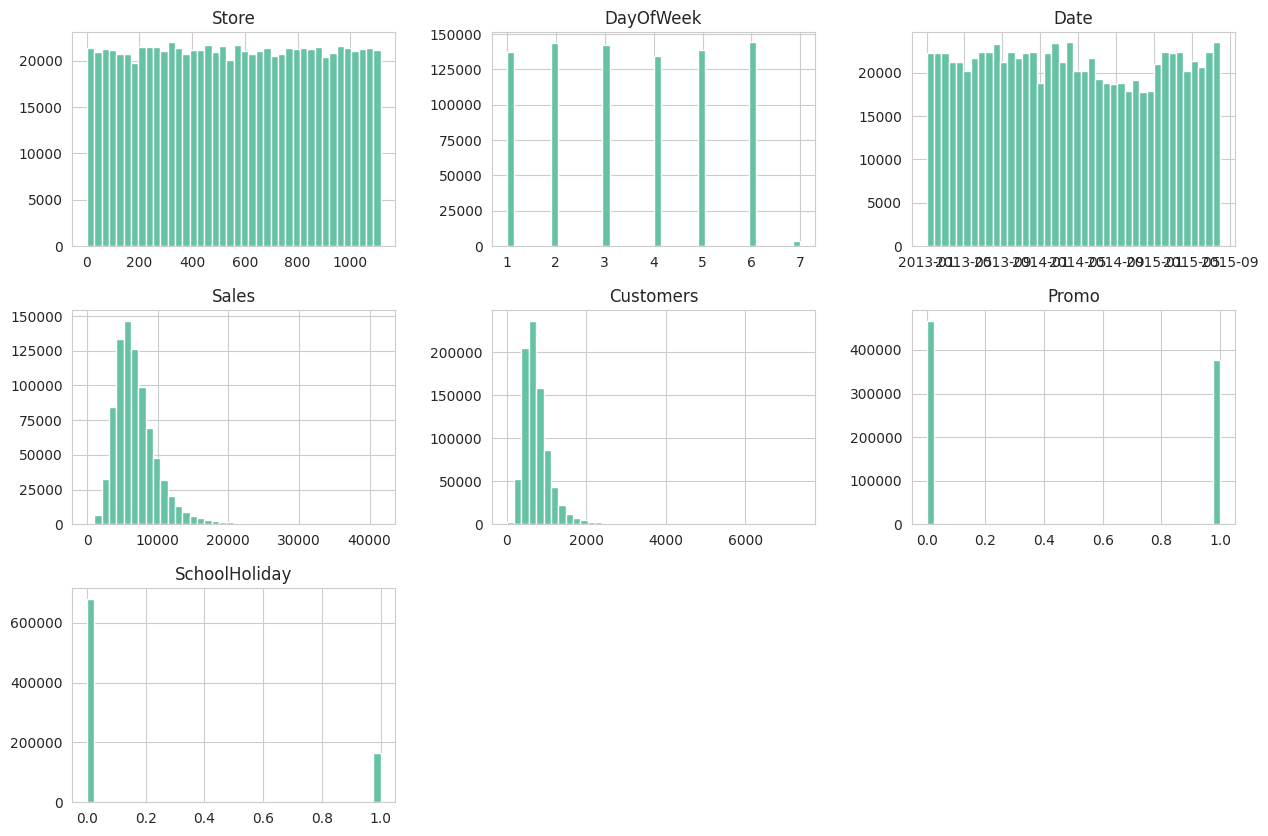

In [18]:
vendas_df.hist(figsize=(15, 10), bins = 40)
plt.show()

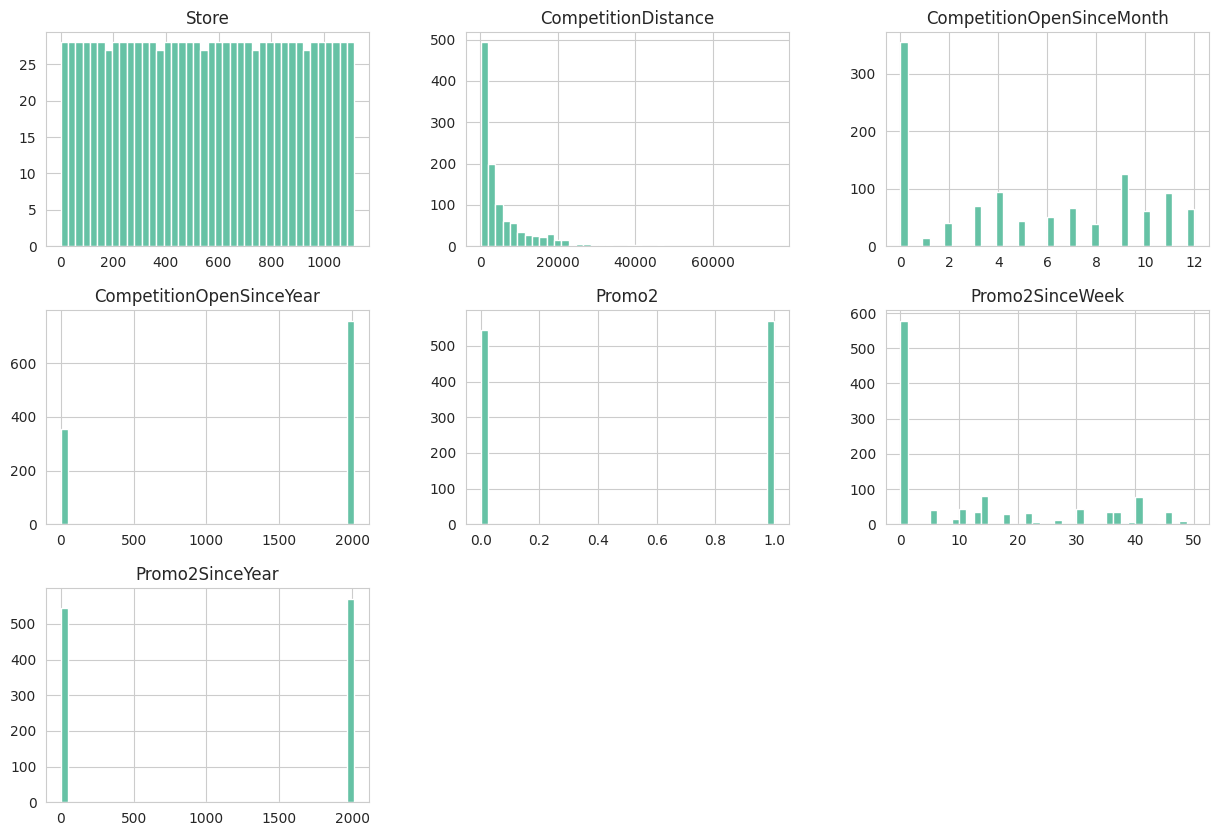

In [19]:
lojas_df.hist(figsize=(15, 10), bins = 40)
plt.show()

Junção das bases de dados

In [20]:
df = pd.merge(vendas_df, lojas_df, on='Store', how='inner')
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


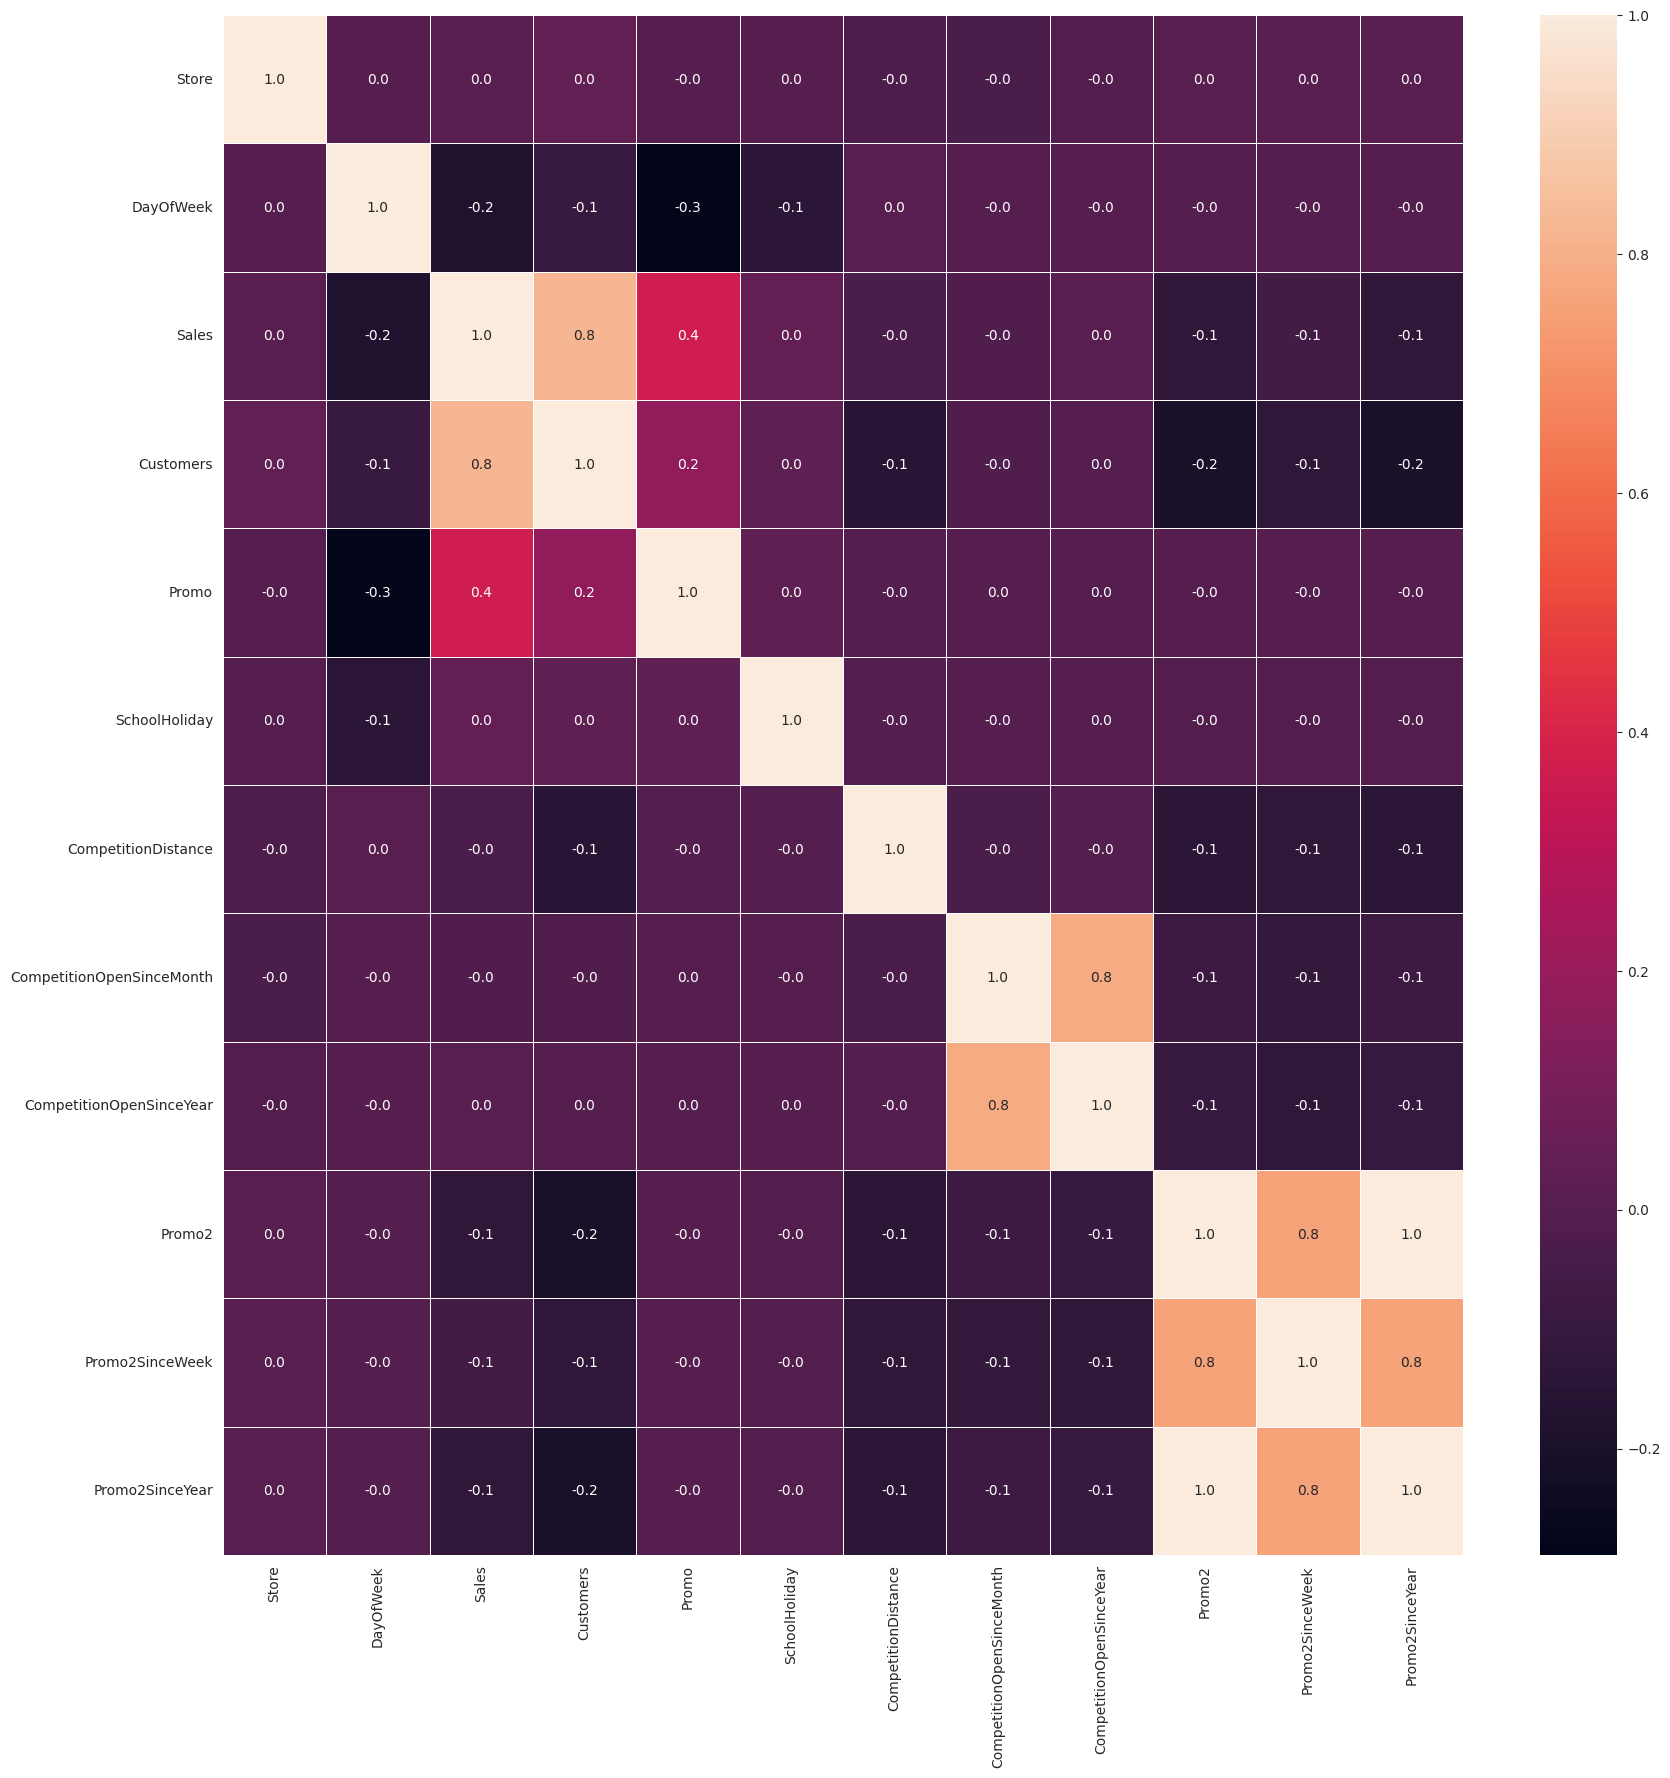

In [21]:
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(numeric_only=True), annot=True, linewidths=.5, fmt='.1f', ax=ax)
plt.show()

In [22]:
df.corr(numeric_only=True)['Sales'].sort_values()

,Sales
DayOfWeek,-0.178736
Promo2SinceYear,-0.127621
Promo2,-0.127596
Promo2SinceWeek,-0.058476
CompetitionDistance,-0.036343
CompetitionOpenSinceMonth,-0.018370
CompetitionOpenSinceYear,0.005266
Store,0.007710
SchoolHoliday,0.038617
Promo,0.368145


In [23]:
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Day'] = pd.DatetimeIndex(df['Date']).day
df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,2,5,2015-07-31,6064,625,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31
2,3,5,2015-07-31,8314,821,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31
3,4,5,2015-07-31,13995,1498,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2015,7,31
4,5,5,2015-07-31,4822,559,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,2015,7,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,682,2,2013-01-01,3375,566,0,a,1,b,a,150.0,9.0,2006.0,0,0.0,0.0,0,2013,1,1
844388,733,2,2013-01-01,10765,2377,0,a,1,b,b,860.0,10.0,1999.0,0,0.0,0.0,0,2013,1,1
844389,769,2,2013-01-01,5035,1248,0,a,1,b,b,840.0,0.0,0.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1
844390,948,2,2013-01-01,4491,1039,0,a,1,b,b,1430.0,0.0,0.0,0,0.0,0.0,0,2013,1,1


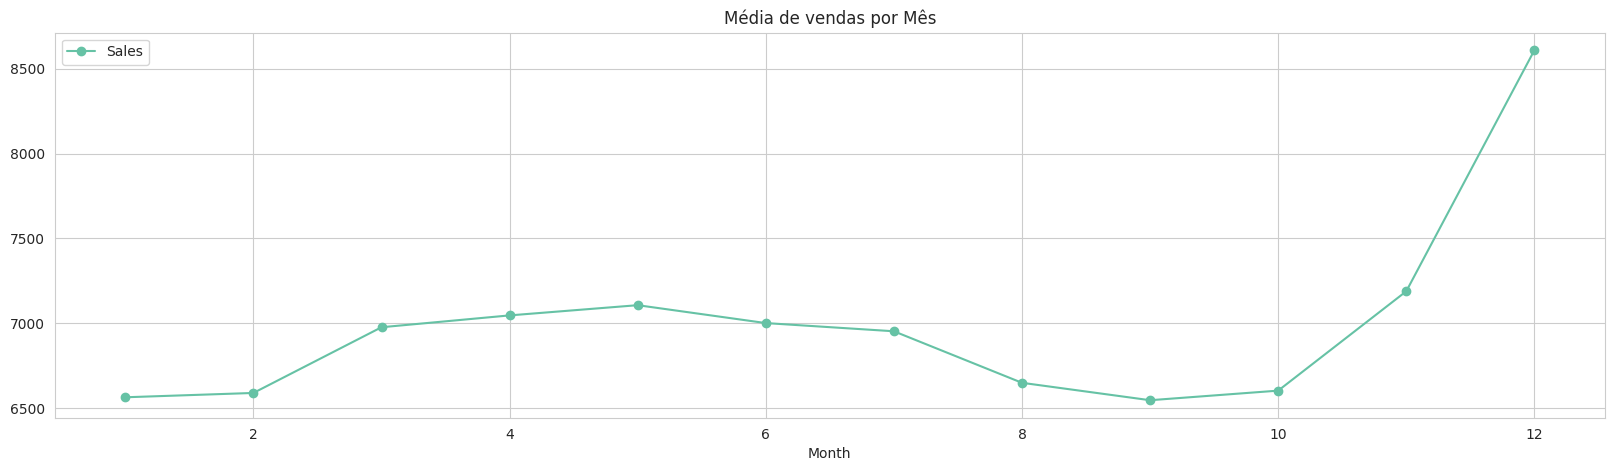

In [24]:
axis = df.groupby('Month')[['Sales']].mean().plot(figsize=(20,5), marker = 'o')
axis.set_title('Média de vendas por Mês')
plt.show()

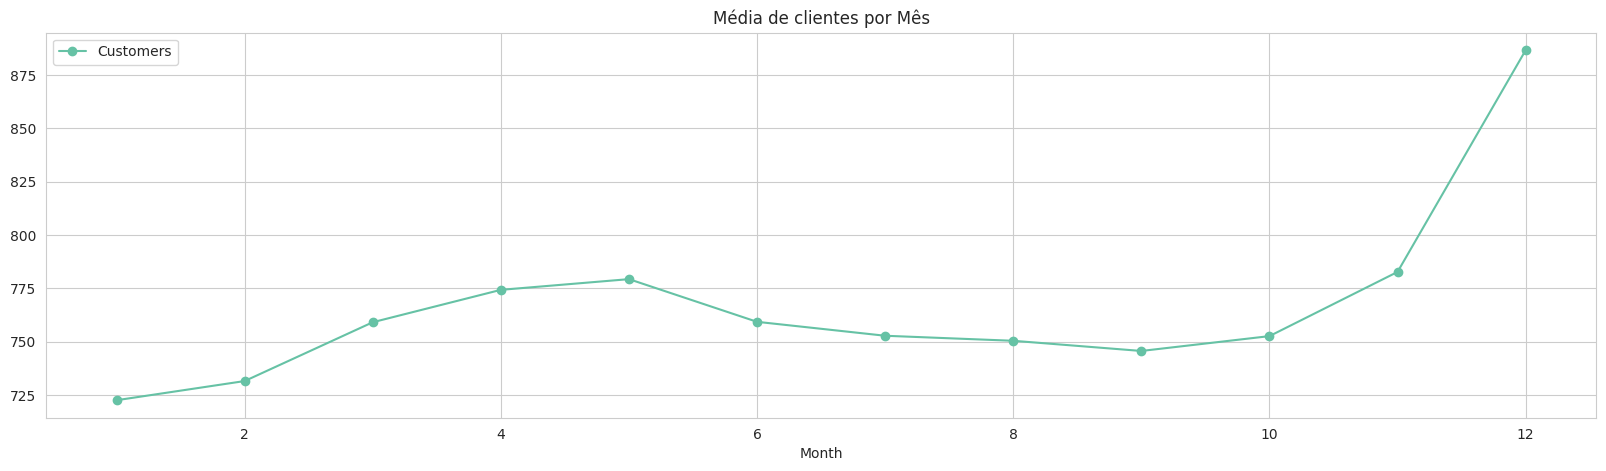

In [25]:
axis = df.groupby('Month')[['Customers']].mean().plot(figsize=(20,5), marker = 'o')
axis.set_title('Média de clientes por Mês')
plt.show()

***Nos 2 últimos meses do ano o clientes costumam gastar mais.***




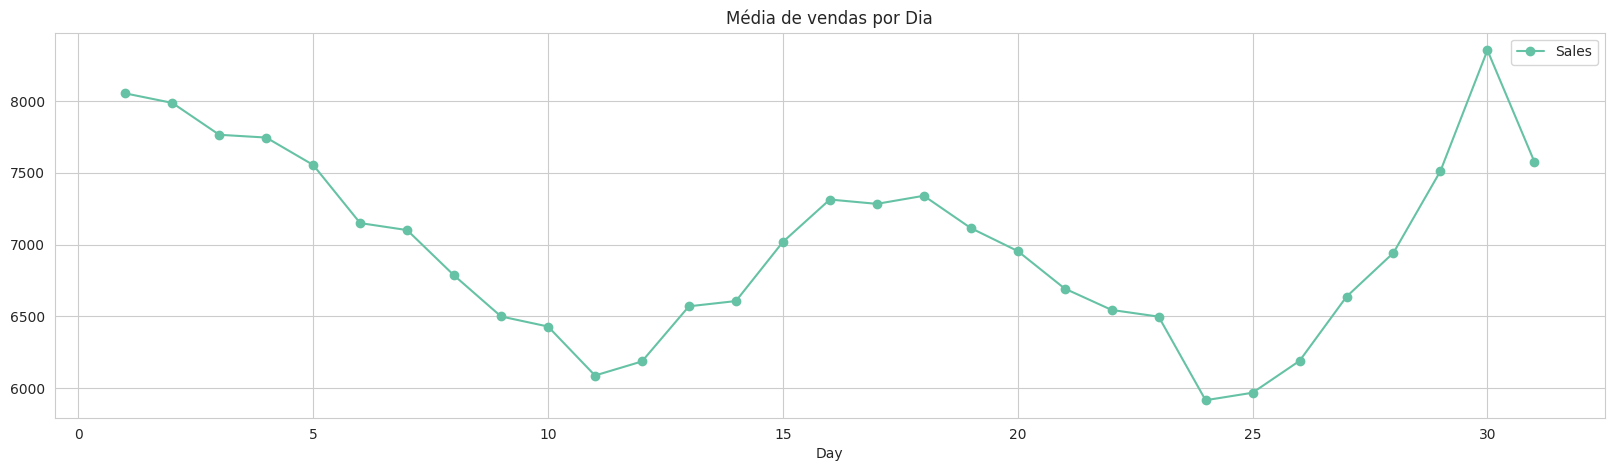

In [26]:
axis = df.groupby('Day')[['Sales']].mean().plot(figsize=(20,5), marker = 'o')
axis.set_title('Média de vendas por Dia')
plt.show()

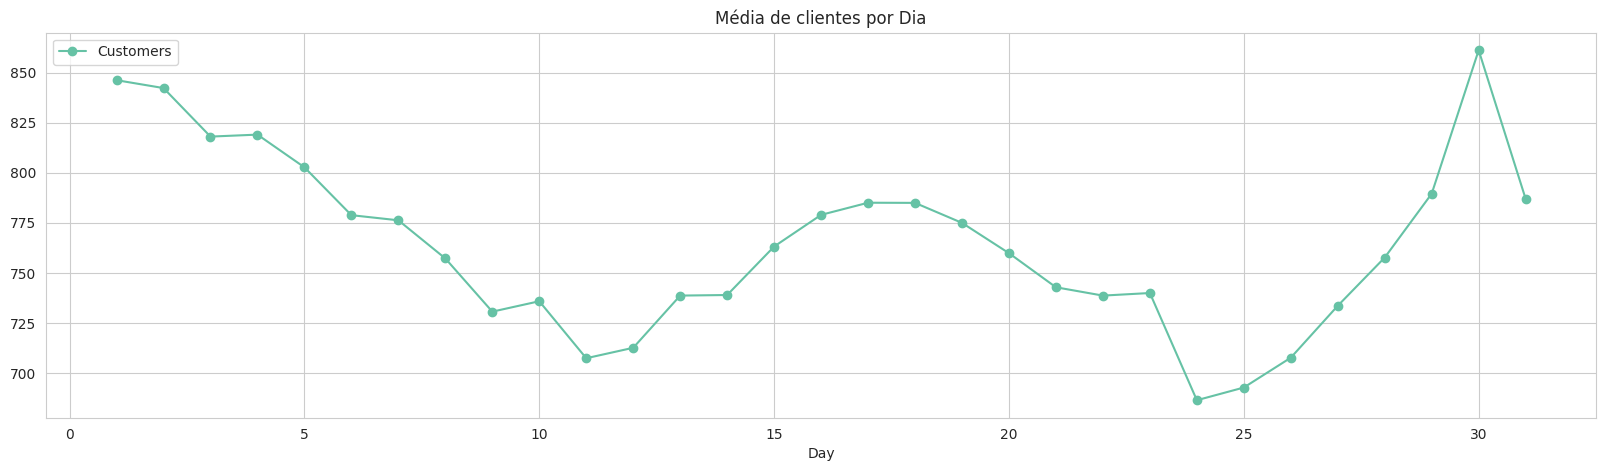

In [27]:
axis = df.groupby('Day')[['Customers']].mean().plot(figsize=(20,5), marker = 'o')
axis.set_title('Média de clientes por Dia')
plt.show()

***No início e no final dos meses as vendas aumentam.***

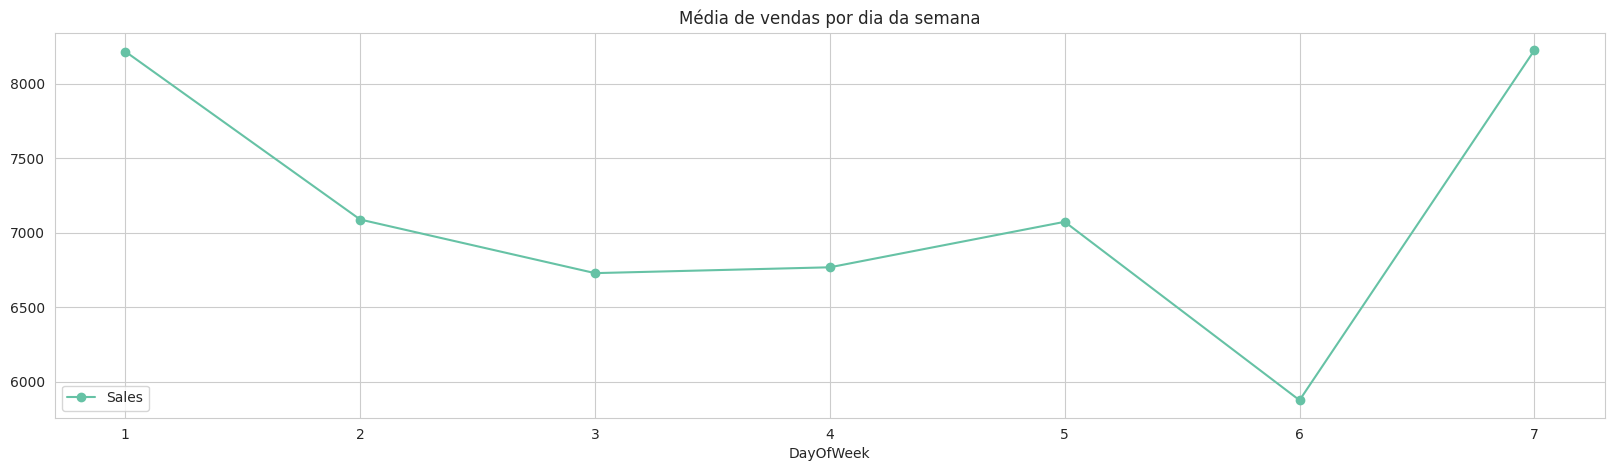

In [28]:
axis = df.groupby('DayOfWeek')[['Sales']].mean().plot(figsize=(20,5), marker = 'o')
axis.set_title('Média de vendas por dia da semana')
plt.show()

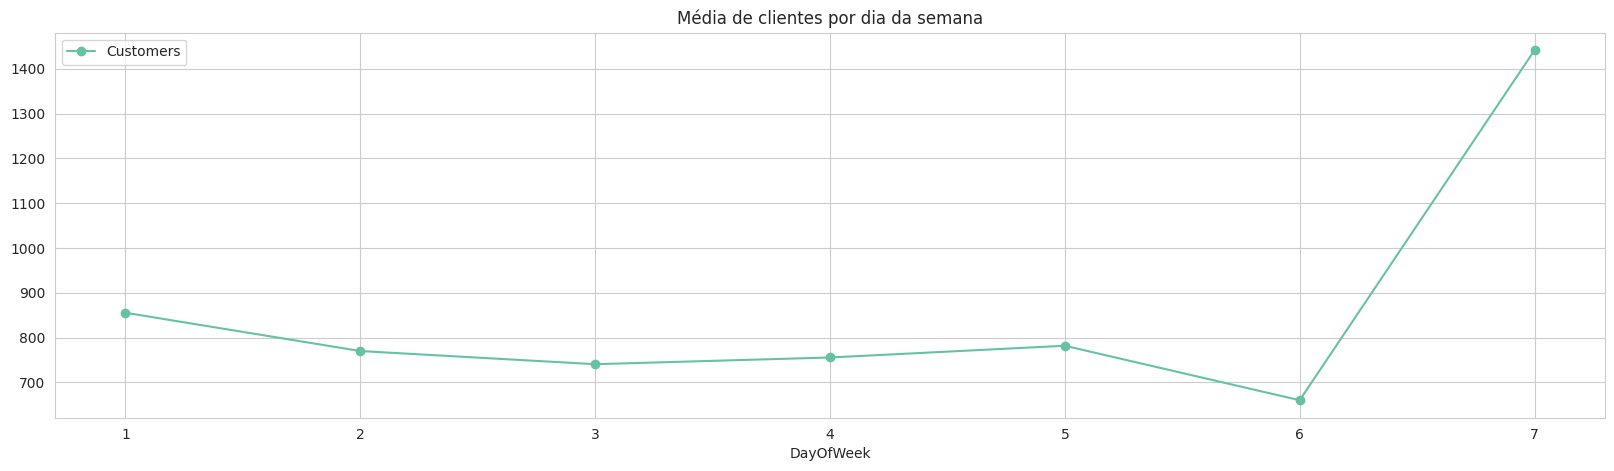

In [29]:
axis = df.groupby('DayOfWeek')[['Customers']].mean().plot(figsize=(20,5), marker = 'o')
axis.set_title('Média de clientes por dia da semana')
plt.show()

***Domingo(7) e Segunda(1) os clientes costumam gastar mais (apesar de que na segunda o número de clientes não é tão alto), Sábados(6) gastam menos.***

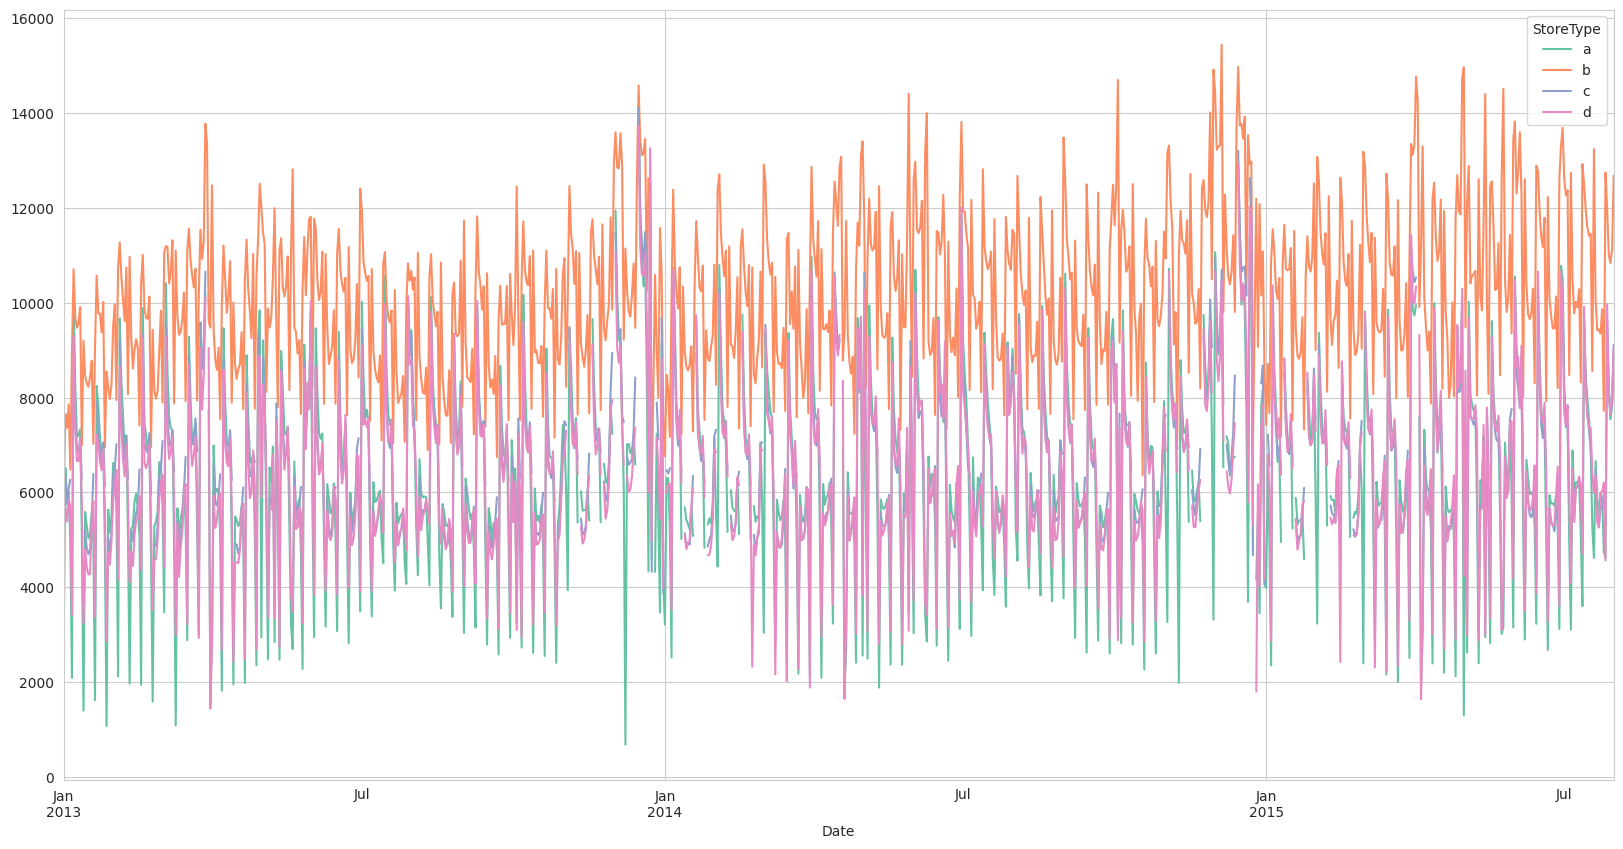

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
df.groupby(['Date', 'StoreType'])['Sales'].mean().unstack().plot(ax=ax)
plt.show();

***Lojas tipo B tem maior média de vendas e Lojas do tipo A em média vendem menos.***

# Hipóteses

- **H1:** Dias com promoção apresentam um aumento nas vendas e, possivelmente, no número de clientes.



teste-T para efeito de Promoção nas Vendas:
t-statistic: 356.64, p-value: 0.0000
teste-T para efeito de Promoção no Número de clientes:
t-statistic: 170.33, p-value: 0.0000


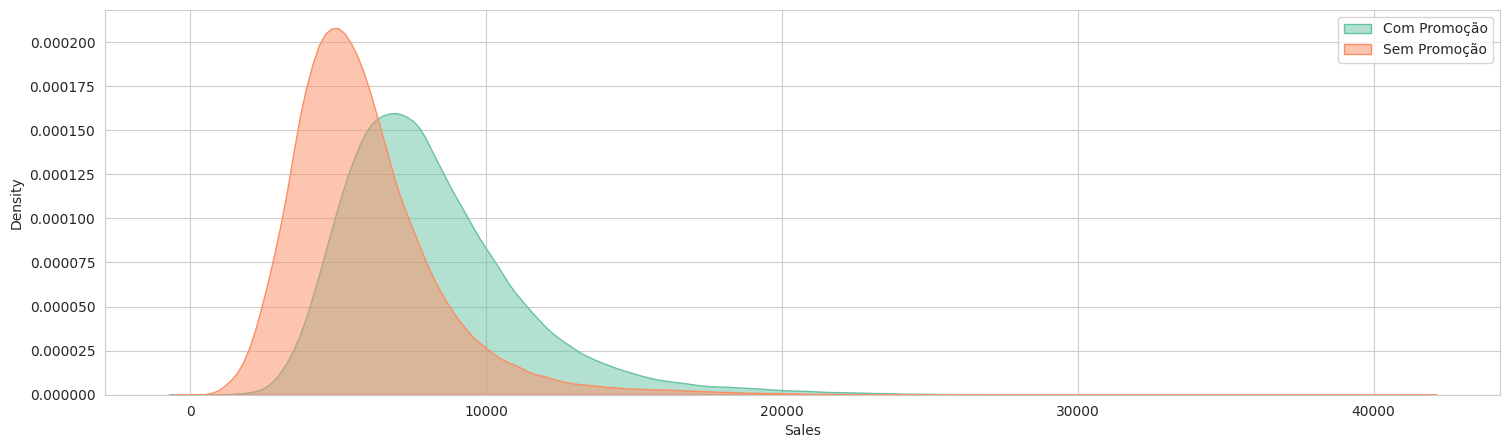

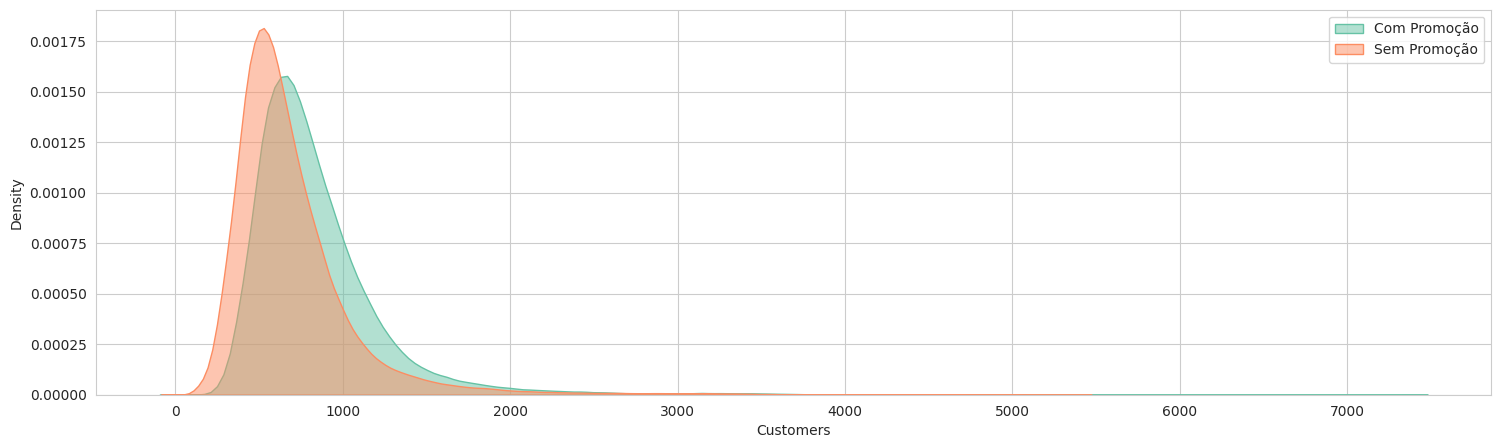

In [31]:
t_stat, p_val = ttest_ind(df[df['Promo'] == 1]["Sales"], df[df['Promo'] == 0]["Sales"], equal_var=False)
print("teste-T para efeito de Promoção nas Vendas:")
print(f"t-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")

t_stat, p_val = ttest_ind(df[df['Promo'] == 1]["Customers"], df[df['Promo'] == 0]["Customers"], equal_var=False)
print("teste-T para efeito de Promoção no Número de clientes:")
print(f"t-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")

# Visualização com boxplot
plt.figure(figsize=(18, 5))
sns.kdeplot(df[df['Promo'] == 1]["Sales"], label='Com Promoção', fill=True, alpha=0.5)
sns.kdeplot(df[df['Promo'] == 0]["Sales"], label='Sem Promoção', fill=True, alpha=0.5)
plt.legend();

plt.figure(figsize=(18, 5))
sns.kdeplot(df[df['Promo'] == 1]["Customers"], label='Com Promoção', fill=True, alpha=0.5)
sns.kdeplot(df[df['Promo'] == 0]["Customers"], label='Sem Promoção', fill=True, alpha=0.5)
plt.legend();

***Os resultados dos testes t e gráficos mostram que a promoção teve um efeito estatisticamente significativo tanto nas vendas quanto no número de clientes. Isso significa que as promoções foram eficazes em aumentar as vendas e atrair mais clientes.***

- **H2:** Certos tipos de loja (StoreType) podem estar associados a níveis específicos de mix de produtos (Assortment).  

In [32]:
chi2, p, dof, freq_esperadas = chi2_contingency(pd.crosstab(lojas_df["StoreType"], lojas_df["Assortment"]))
print("\nTeste Qui-Quadrado para StoreType vs Assortment:")
print(f"Chi2: {chi2:.2f}, p-valor: {p:.4f}, dof: {dof}")


Teste Qui-Quadrado para StoreType vs Assortment:
Chi2: 650.74, p-valor: 0.0000, dof: 6


***Os resultados indicam que há uma associação estatisticamente significativa entre os tipos de loja e os níveis de mix de produtos. Isso significa que certos tipos de loja estão associados a níveis específicos de mix de produtos, conforme esperado.***

- **H3:** Lojas que participam do Promo2 por períodos mais longos ou com intervalos específicos podem ter desempenho de vendas diferente.  

In [33]:
t_stat2, p_val2 = ttest_ind(df[df['Promo2'] == 1]['Sales'], df[df['Promo2'] == 0]['Sales'], equal_var=False)
print("\nteste-T para efeito do Promo2 nas vendas:")
print(f"t-statistic: {t_stat2:.2f}, p-valor: {p_val2:.4f}")


teste-T para efeito do Promo2 nas vendas:
t-statistic: -118.28, p-valor: 0.0000


***Os resultados indicam que a participação no Promo2 tem um efeito significativo nas vendas das lojas. Especificamente, as lojas que participam do Promo2 tendem a ter vendas menores em comparação com as lojas que não participam. Isso pode sugerir que o Promo2 não está sendo tão eficaz quanto esperado ou que elas participam da 'Promo2' justamente por não terem tantas vendas.***

- **H4:** Lojas localizadas próximas de concorrentes (baixa CompetitionDistance) podem ter estratégias ou desempenho diferentes.  

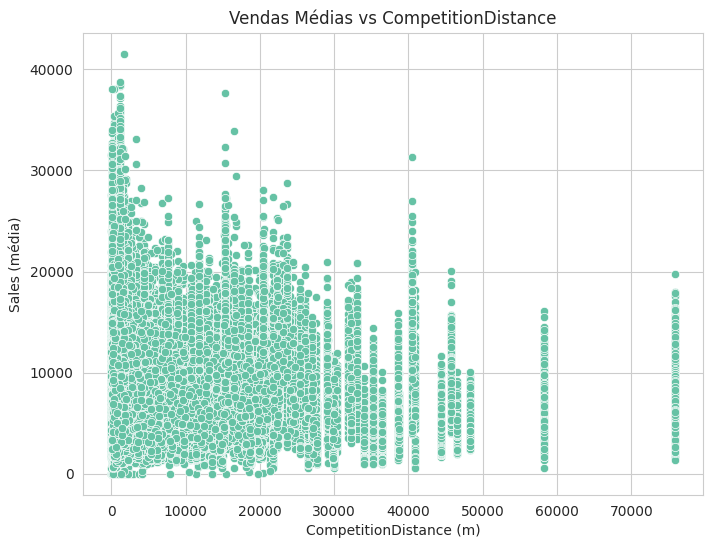


Correlação entre CompetitionDistance e Sales (média): -0.036343460450786


In [34]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="CompetitionDistance", y="Sales", data=df)
plt.title("Vendas Médias vs CompetitionDistance")
plt.xlabel("CompetitionDistance (m)")
plt.ylabel("Sales (média)")
plt.show()

corr = df["CompetitionDistance"].corr(df["Sales"])
print("\nCorrelação entre CompetitionDistance e Sales (média):", corr)

***Embora haja uma correlação negativa entre a distância dos concorrentes e as vendas, a relação é muito fraca. Isso significa que a proximidade dos concorrentes não tem um impacto significativo nas vendas das lojas.***

# Criação de Modelo

Objetivo será criar uma função que receba o id da loja, base de dados e quantos dias queremos prever.

In [35]:
def previsao(loja_id, dados, periodo_previsao):
  dados = dados[dados['Store'] == loja_id]
  dados = dados[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})
  dados = dados.sort_values(by='ds')

  modelo = Prophet()
  modelo.fit(dados)
  futuro = modelo.make_future_dataframe(periods=periodo_previsao)
  previsoes = modelo.predict(futuro)
  figura1 = modelo.plot(previsoes)
  figura2 = modelo.plot_components(previsoes)

  return dados, previsoes

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwti0cl3z/tf2u3u9o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwti0cl3z/ax28yikw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92842', 'data', 'file=/tmp/tmpwti0cl3z/tf2u3u9o.json', 'init=/tmp/tmpwti0cl3z/ax28yikw.json', 'output', 'file=/tmp/tmpwti0cl3z/prophet_modelqj_ejpiw/prophet_model-20250204221418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:14:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:14:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


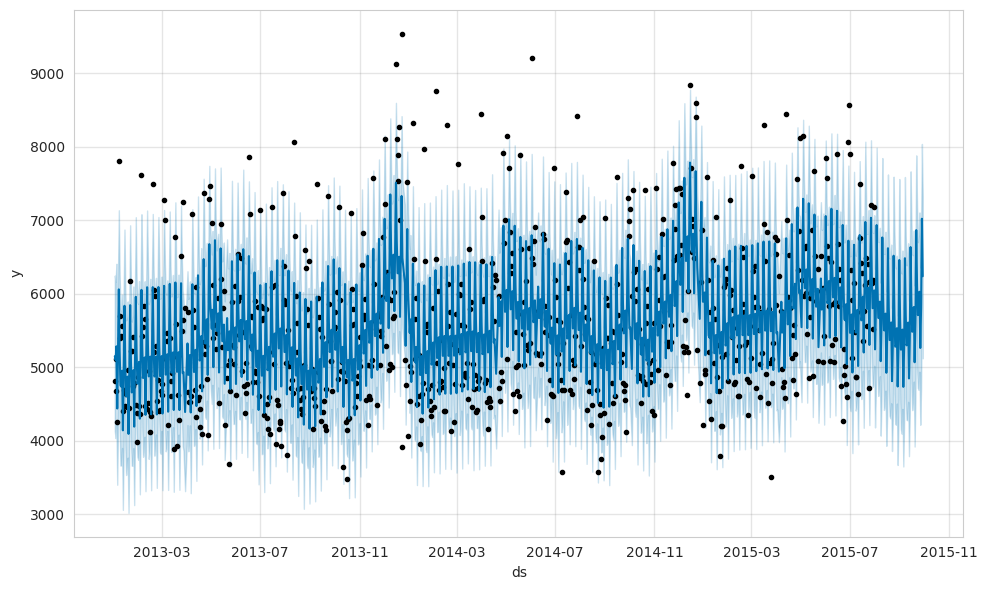

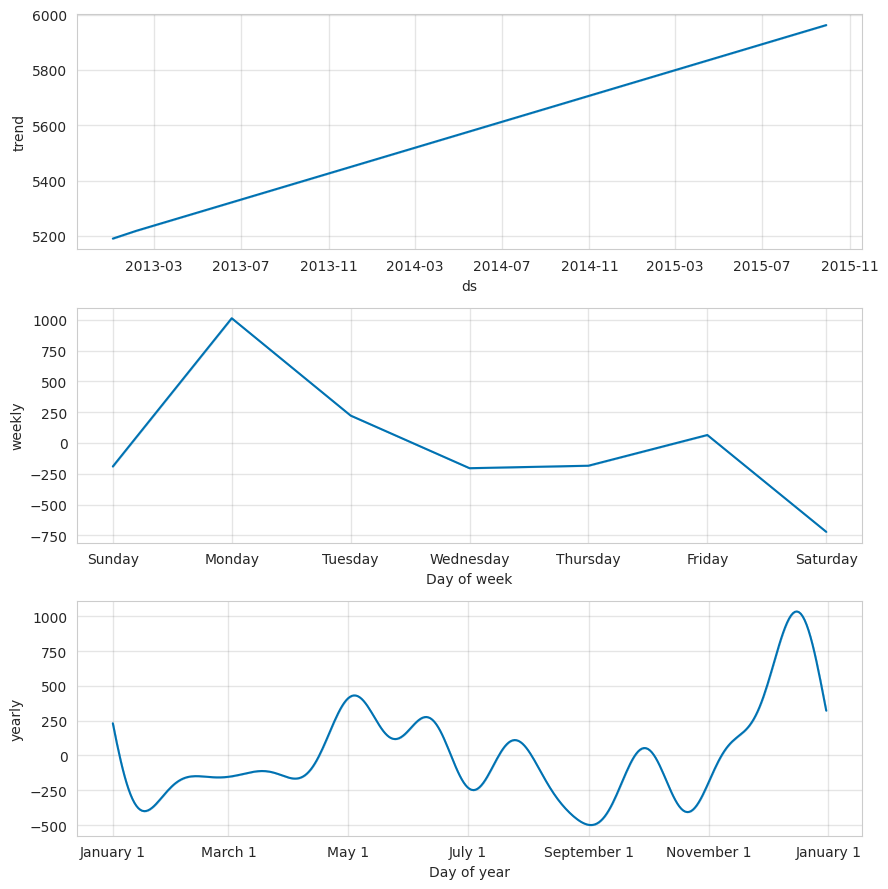

In [36]:
df_original, df_previsao = previsao(10, df, 60)

In [37]:
# Calcular o RMSE
rmse = np.sqrt(np.mean((np.array(df_original['y']) - np.array(df_previsao[:784]['yhat'])) ** 2))

In [38]:
print("MAE:", mean_absolute_error(df_original['y'], df_previsao[:784]['yhat']))
print("MSE:", mean_squared_error(df_original['y'], df_previsao[:784]['yhat']))
print("RMSE:", root_mean_squared_error(df_original['y'], df_previsao[:784]['yhat']))
print("MAPE:", mean_absolute_percentage_error(df_original['y'], df_previsao[:784]['yhat']))

MAE: 653.01095950488
MSE: 674035.1807196753
RMSE: 820.9964559726645
MAPE: 0.1185749461746218


Criação de documento apenas com as previsões dos próximos 2 meses da loja número 10

In [39]:
df_previsao['yhat'].tail(60).to_csv('proximos_2meses.csv', index=False)

Criação de modelo com informações dos feriados


- SchoolHoliday: indica se a loja foi afetada por algum feriado escolar.

- StateHoliday: As escolas estão fechadas nesses feriados e nos finais de semana. Legenda: a = public holiday, b = páscoa, c = natal, 0 = nenhum feriado.

In [40]:
def previsao_feriados(loja_id, dados, periodo_previsao):
    """
    Função para prever vendas futuras de uma loja específica, considerando feriados escolares e estaduais.

    Parâmetros:
    loja_id (int): ID da loja para a qual queremos fazer a previsão.
    dados (DataFrame): DataFrame contendo os dados históricos de vendas.
    periodo_previsao (int): Número de dias para os quais queremos fazer a previsão.

    Retorna:
    dados (DataFrame): Dados filtrados e preparados para a loja específica.
    previsoes (DataFrame): Previsões geradas pelo modelo Prophet.
    """

    # Filtrar os dados para a loja específica
    dados = dados[dados['Store'] == loja_id]

    # Renomear colunas conforme exigido pelo modelo Prophet
    dados = dados[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})

    # Ordenar os dados pela coluna de datas
    dados = dados.sort_values(by='ds')

    # Identificar feriados escolares e estaduais
    feriados_escolares = df[df['SchoolHoliday'] == 1].loc[:, 'Date'].values
    feriados_estaduais = df[(df['StateHoliday'] == 'a') | (df['StateHoliday'] == 'b') | (df['StateHoliday'] == 'c')].loc[:, 'Date'].values

    # Combinar feriados escolares e estaduais em um único DataFrame
    feriados = pd.concat([pd.DataFrame({'ds': feriados_estaduais, 'holiday': 'state_holiday'}),
                          pd.DataFrame({'ds': feriados_escolares, 'holiday': 'school_holiday'})])

    # Criar e treinar o modelo Prophet, incluindo os feriados
    modelo = Prophet(holidays=feriados)
    modelo.fit(dados)

    # Criar DataFrame futuro para previsões
    futuro = modelo.make_future_dataframe(periods=periodo_previsao)

    # Gerar previsões
    previsoes = modelo.predict(futuro)

    # Plotar previsões e componentes das previsões
    figura1 = modelo.plot(previsoes)
    figura2 = modelo.plot_components(previsoes)

    return dados, previsoes


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwti0cl3z/u13q9ytr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwti0cl3z/0ww29kyo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84', 'data', 'file=/tmp/tmpwti0cl3z/u13q9ytr.json', 'init=/tmp/tmpwti0cl3z/0ww29kyo.json', 'output', 'file=/tmp/tmpwti0cl3z/prophet_modelim417j2k/prophet_model-20250204221439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:14:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:14:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


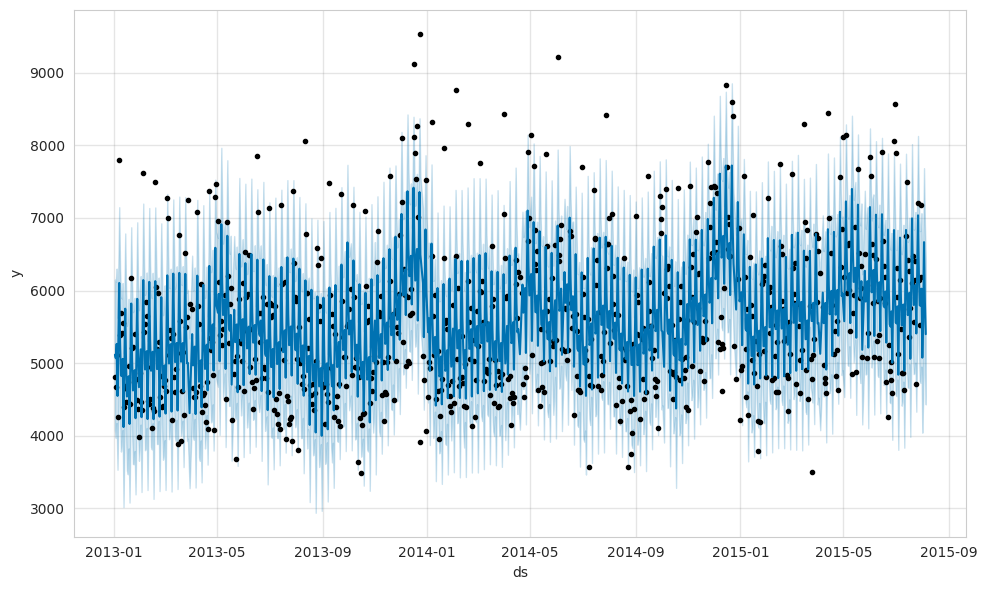

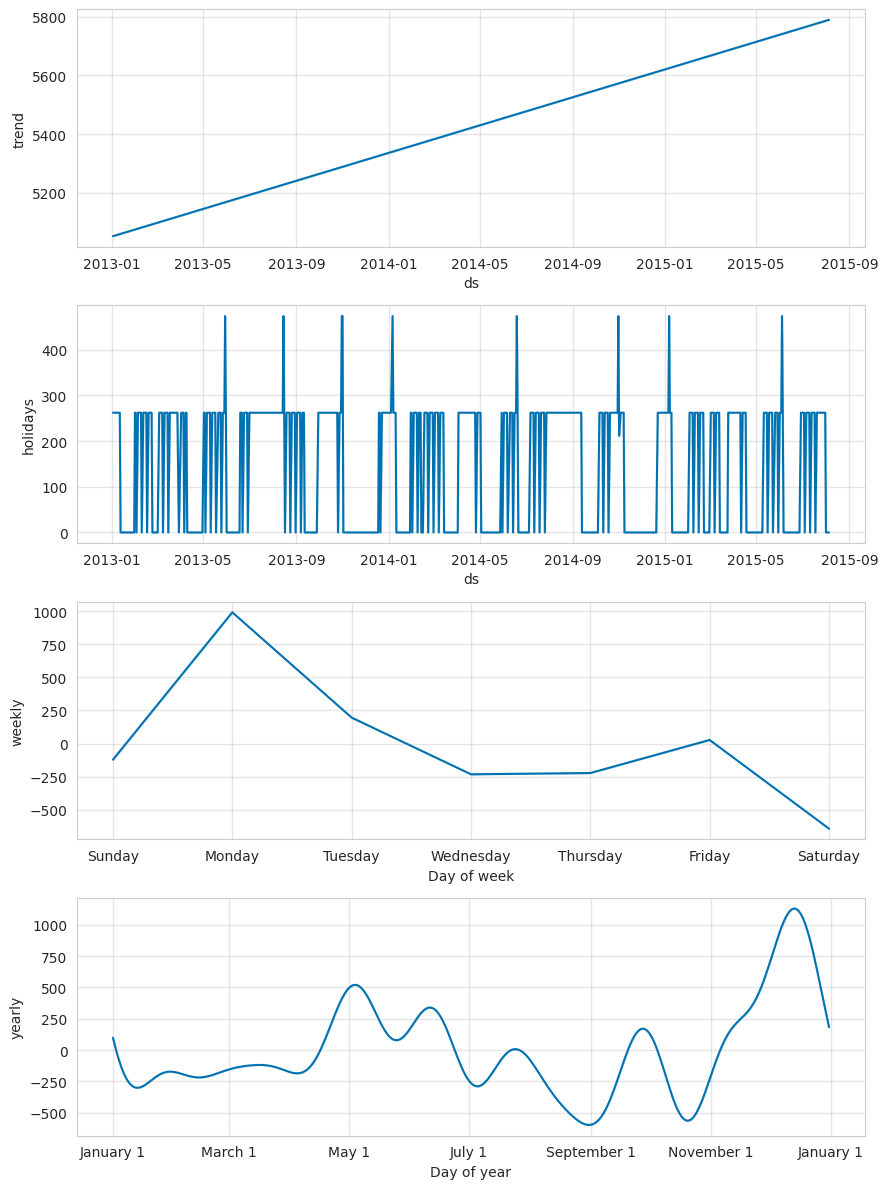

In [41]:
df_original, df_previsao = previsao_feriados(10, df, 5)

In [42]:
print("MAE:", mean_absolute_error(df_original['y'], df_previsao[:784]['yhat']))
print("MSE:", mean_squared_error(df_original['y'], df_previsao[:784]['yhat']))
print("RMSE:", root_mean_squared_error(df_original['y'], df_previsao[:784]['yhat']))
print("MAPE:", mean_absolute_percentage_error(df_original['y'], df_previsao[:784]['yhat']))

MAE: 648.3764522938585
MSE: 664607.0041342087
RMSE: 815.2343246786219
MAPE: 0.11775315590006794


# Conclusão:

 - ***Mesmo usando a opção de feriados para o modelo não tratar esses feriados como outliers, não deu tanta diferença nas métricas de avaliação. Usaria o primeiro modelo pois usa menos processamento computacional.***